## Donald Trump's Speeches in his Second Term of Presidency: A Natural Language Processing based analysis using NLTK and a BERT based transformer

**By Syed Faizan**

I used Donald.J.Trump's speeches as the subject of my NLP based analysis using NLTK package and a BERT based transformer for Sentiment Analysis (presented in another notebook as an addendum).

I begin by downloading all the Selenium and Beautiful Soup dependencies needed to scrape the presidential speeches. The source of our speeches of the subject, Donald. J. Trump, in his second term which commenced on the 20th of last month (January 2025) shall be the **'American Presidency Project'** maintained by the University of Santa Barbara. 

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time
import pandas as pd



We set up the Selenium Webdriver

In [3]:
# Set up Selenium WebDriver
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # Run in headless mode
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)



The URL of the University of Santa Barbara maintained website is specified.

In [4]:


# UCSB Presidency Project URL (Filtered Speeches)
url = "https://www.presidency.ucsb.edu/advanced-search?field-keywords=&field-keywords2=&field-keywords3=&from%5Bdate%5D=&to%5Bdate%5D=&person2=375125&category2%5B%5D=74&category2%5B%5D=8&category2%5B%5D=46&category2%5B%5D=48&category2%5B%5D=65&items_per_page=25"

driver.get(url)
time.sleep(3)  # Wait for the page to load




We initiate a function to extract the speeches, numbering 15 *in toto* from the website. 

In [5]:
# Function to extract speech links from all pages
def get_speech_links():
    speech_links = []
    while True:
        # Wait for search results to load
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "views-field-title")))

        # Extract all speech links on the page
        speeches = driver.find_elements(By.CSS_SELECTOR, ".views-field-title a")
        for speech in speeches:
            speech_links.append(speech.get_attribute("href"))

        # Check if a "Next" button exists, if yes, click and continue
        try:
            next_button = driver.find_element(By.XPATH, "//a[contains(text(),'next ›')]")
            driver.execute_script("arguments[0].click();", next_button)  # Scrolls and clicks
            time.sleep(3)  # Wait for the next page to load
        except:
            break  # No more pages, exit loop

    return speech_links



The links are secured. 

In [6]:
# Get all speech links
speech_urls = get_speech_links()
print(f"Found {len(speech_urls)} speeches.")

# Function to scrape speech content
def scrape_speech(url):
    driver.get(url)
    time.sleep(2)  # Wait for the page to load
    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Extract speech title
    try:
        title = soup.find("h1", class_="title").text.strip()
    except:
        title = "No Title"

    # Extract speech date
    try:
        date = soup.find("span", class_="date-display-single").text.strip()
    except:
        date = "No Date"

    # Extract speech text
    try:
        speech_text = soup.find("div", class_="field-docs-content").text.strip()
    except:
        speech_text = "No Speech Text"

    return {"Title": title, "Date": date, "Text": speech_text, "URL": url}

# Scrape all speeches
speeches_data = []
for idx, speech_url in enumerate(speech_urls):
    print(f"Scraping {idx+1}/{len(speech_urls)}: {speech_url}")
    speeches_data.append(scrape_speech(speech_url))

# Save to CSV
df = pd.DataFrame(speeches_data)
df.to_csv("Trump_addresses.csv", index=False, encoding="utf-8")
print("Scraping Complete! Data saved as 'presidential_speeches.csv'.")

# Close Selenium browser
driver.quit()

Found 15 speeches.
Scraping 1/15: https://www.presidency.ucsb.edu/documents/remarks-the-liberty-ball
Scraping 2/15: https://www.presidency.ucsb.edu/documents/inaugural-address-54
Scraping 3/15: https://www.presidency.ucsb.edu/documents/remarks-following-the-inaugural-ceremony-the-united-states-capitol
Scraping 4/15: https://www.presidency.ucsb.edu/documents/remarks-document-signing-ceremony-and-exchange-with-reporters-the-united-states-capitol
Scraping 5/15: https://www.presidency.ucsb.edu/documents/remarks-the-starlight-ball
Scraping 6/15: https://www.presidency.ucsb.edu/documents/remarks-the-world-economic-forum-0
Scraping 7/15: https://www.presidency.ucsb.edu/documents/remarks-signing-executive-order-and-exchange-with-reporters
Scraping 8/15: https://www.presidency.ucsb.edu/documents/remarks-exchange-with-reporters-departure-from-los-angeles-california
Scraping 9/15: https://www.presidency.ucsb.edu/documents/remarks-during-briefing-hurricane-helene-and-exchange-with-reporters-fletch

## Begin the Natural Language Processing based analysis:
Text Preprocessing shall be first undertaken. Punctuation, stop words, digits shall be removed. Lemmatization undertaken using nltk package. Also, the Parts of speech tag shall be applied to each word in the preprocessed speeches for grammatical analysis. 

In [7]:
# importing the necessary modules
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

NLTK requires several downloads of modules that are necessary for the natural language processing to function without any glitches. My experience working with the NLTK library has informed me that it is better to install this downloads right at the outset to prevent errors in the code. 

In [9]:
 # Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker_tab')  # Named Entity Chunking Model
nltk.download('words')              # Word List
nltk.download('punkt_tab')              # Sentence Tokenizer
nltk.download('averaged_perceptron_tagger')  # POS Tagger


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sfaiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sfaiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     C:\Users\sfaiz\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\sfaiz\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sfaiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sfaiz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-

True

In [10]:
# Load the dataset
df = pd.read_csv("Trump_addresses.csv")


We use lemmatization in order to parse the sentences and use a preprocessing function that prepares the dataset consisting of roughly 23,000 words for the NLP. 

In [11]:
# Initialize Lemmatizer and Stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

We devise a preprocessing function. 

In [12]:
# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = word_tokenize(text)  # Tokenize words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]  # Lemmatize & remove stopwords
    return " ".join(words)

In [13]:
# Apply preprocessing
df["Cleaned_Text"] = df["Text"].astype(str).apply(preprocess_text)

# Save cleaned data
df.to_csv("Trump_addresses_cleaned.csv", index=False)
print("Preprocessing Complete!")

Preprocessing Complete!


## Word Frequency Analysis

We commence our natural language processing in earnest with a frequency analysis of the words in the speeches of President Donald Trump. 

In [21]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud



A note on the retention of the markers `Applause` and `Laughter` in the text even after preprocessing to help us investigate the audience reaction. 

**Audience Reception** - I have deliberately retained the interpolated words 'applause' and 'laughter' in the speeches as indicative of how many times the speeches were interrupted by laughter and applause. 

In [24]:
from collections import Counter

# Tokenize all words from the speeches
all_words = " ".join(df["Cleaned_Text"]).split()

# Count word occurrences
word_freq = Counter(all_words)

# Get specific counts
applause_count = word_freq.get("applause", 0)
laughter_count = word_freq.get("laughter", 0)

# Print results
print(f"Occurrences of 'applause': {applause_count}")
print(f"Occurrences of 'laughter': {laughter_count}")


Occurrences of 'applause': 163
Occurrences of 'laughter': 130


Visualization of how often the speeches were interrupted with applause or laughter.

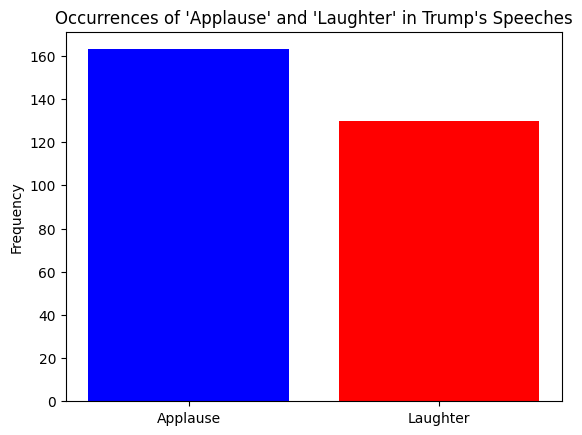

In [25]:
import matplotlib.pyplot as plt

# Bar chart
plt.bar(["Applause", "Laughter"], [applause_count, laughter_count], color=["blue", "red"])
plt.ylabel("Frequency")
plt.title("Occurrences of 'Applause' and 'Laughter' in Trump's Speeches")
plt.show()


We calculate a frequency of these instances of interruption. 

In [29]:
total_words = len(all_words)

# Frequency of applause 
applause_freq = total_words/applause_count
laughter_freq = total_words/laughter_count

print(f"Total words spoken in official speeches since inauguration were {total_words}: Interrupted by applause every {round(applause_freq)} words and by laughter every {round(laughter_freq)} words")




Total words spoken in official speeches since inauguration were 23981: Interrupted by applause every 147 words and by laughter every 184 words


## Which countries were mentioned the most ?

**Most mentioned countries** : I checked which countries were mentioned the most 


In [93]:
# List of countries (ISO country names)
countries = [
    "america", "china", "canada", "mexico", "russia", "india", "germany", "france", "uk", "uk",
    "japan", "brazil", "italy", "australia", "iran", "north korea", "south korea", "saudi arabia",
    "israel", "ukraine", "afghanistan", "pakistan", "venezuela", "cuba", "turkey", "spain", "gaza", "palestine"
]

# Convert to lowercase for uniformity
all_words_lower = [word.lower() for word in all_words]

# Count occurrences of country names
country_freq = Counter(word for word in all_words_lower if word in countries)

# Get the 20 most frequently mentioned countries
top_30_countries = country_freq.most_common(30)

# Print results
for country, count in top_30_countries:
    print(f"{country.capitalize()}: {count}")

America: 82
China: 36
Israel: 35
Canada: 31
Iran: 26
Gaza: 23
Ukraine: 21
Russia: 17
Mexico: 12
Afghanistan: 5
Italy: 2
France: 2
Venezuela: 1
Japan: 1
Germany: 1


C:\Users\sfaiz\AppData\Local\Temp\ipykernel_71012\1417830327.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(countries)).colors  # 'tab20' provides 30 distinct colors


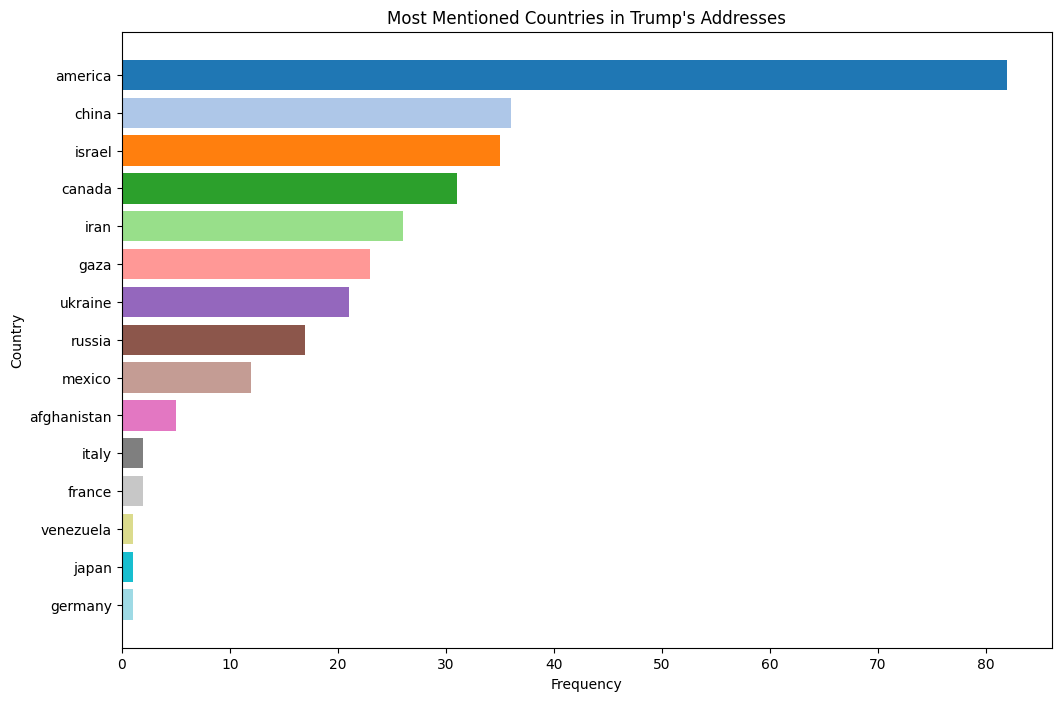

In [94]:
import matplotlib.pyplot as plt

# Extract country names and their counts (Top 30)
countries, counts = zip(*top_30_countries)  # Ensure using top 30

# Generate unique colors for each country using a colormap
colors = plt.cm.get_cmap("tab20", len(countries)).colors  # 'tab20' provides 30 distinct colors

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(countries, counts, color=colors)
plt.xlabel("Frequency")
plt.ylabel("Country")
plt.title("Most Mentioned Countries in Trump's Addresses")
plt.gca().invert_yaxis()  # Reverse order for better readability

# Show the plot
plt.show()



## Which Leaders (American or Foreign) were mentioned the most?

C:\Users\sfaiz\AppData\Local\Temp\ipykernel_71012\491400182.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(leader_names)).colors


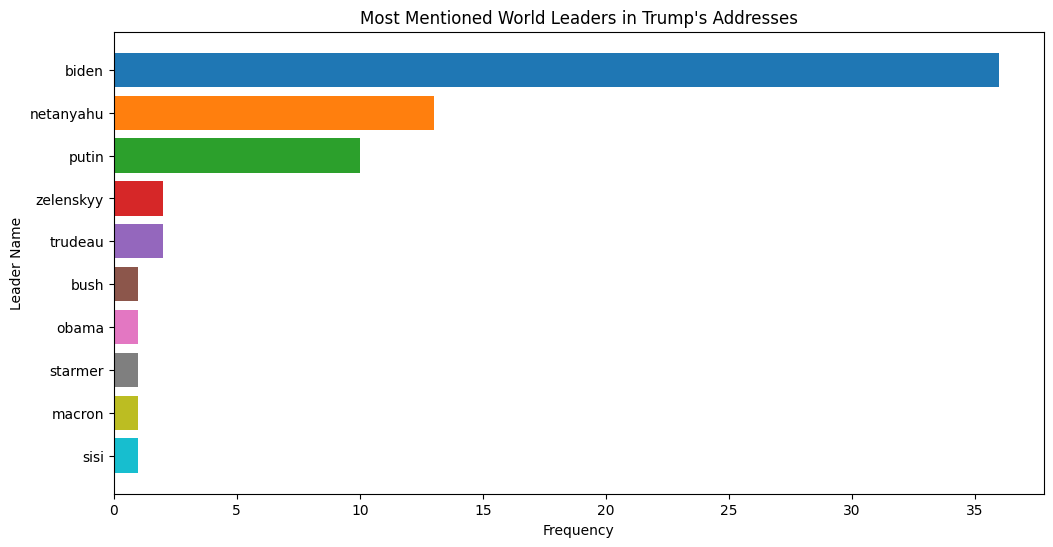

In [83]:
# List of leader names to track
leaders_list = ["trudeau", "netanyahu", "modi","kamala", "macron", "putin", "biden", "xi", "obama", "bush", "kim", "erdogan", "sisi", "zelenskyy", "starmer", "scholz"]

# Tokenize all words from the speeches and convert to lowercase
all_words_lower = [word.lower() for word in " ".join(df["Cleaned_Text"]).split()]

# Count occurrences of leader names
leader_freq = Counter(word for word in all_words_lower if word in leaders_list)

# Get the most frequently mentioned leaders (sorted by frequency)
top_leaders = leader_freq.most_common(len(leaders_list))

# Extract leader names and their counts
leader_names, counts = zip(*top_leaders)

# Generate unique colors for each leader using a colormap
colors = plt.cm.get_cmap("tab10", len(leader_names)).colors

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.barh(leader_names, counts, color=colors)
plt.xlabel("Frequency")
plt.ylabel("Leader Name")
plt.title("Most Mentioned World Leaders in Trump's Addresses")
plt.gca().invert_yaxis()  # Reverse order for better readability

# Show the plot
plt.show()


In [76]:
# Extract leader names and their counts
leader_names, counts = zip(*top_leaders)

for i, y in enumerate(top_leaders):
    print(f"The leader was mentioned {y} times")

The leader was mentioned ('biden', 36) times
The leader was mentioned ('hamas', 14) times
The leader was mentioned ('netanyahu', 13) times
The leader was mentioned ('putin', 10) times
The leader was mentioned ('trudeau', 2) times
The leader was mentioned ('bush', 1) times
The leader was mentioned ('obama', 1) times
The leader was mentioned ('starmer', 1) times
The leader was mentioned ('macron', 1) times
The leader was mentioned ('sisi', 1) times


Interestingly Ukraine was mentioned several times but not zelensky. 

# Most frequently mentioned Topics 

C:\Users\sfaiz\AppData\Local\Temp\ipykernel_71012\3165979596.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(topic_names)).colors


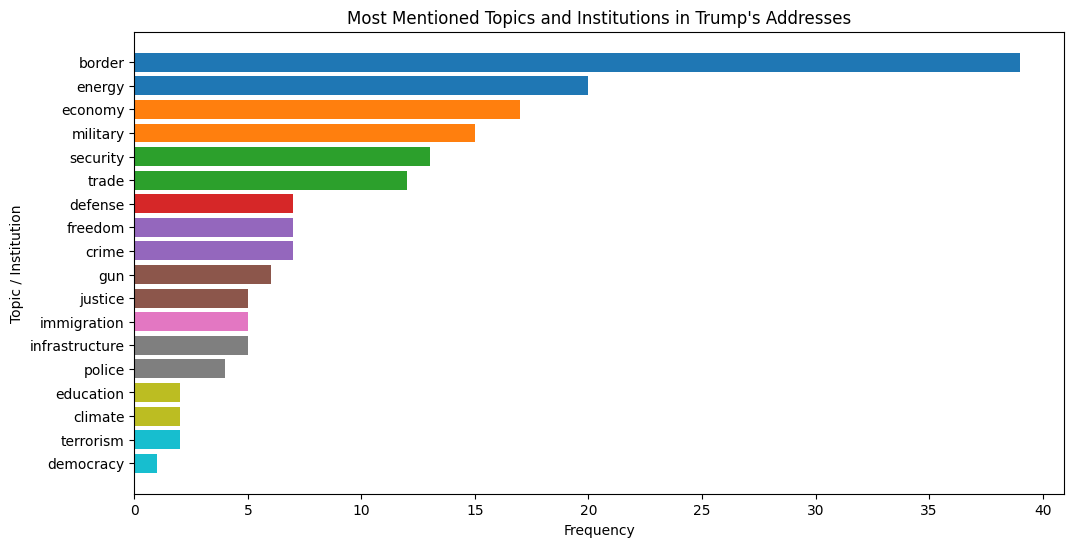

In [40]:
# List of institutions and topics to track
topics_list = [
    "military", "economy", "police", "immigration", "healthcare", "education", "trade", "taxes", "infrastructure",
    "terrorism", "border", "jobs", "law enforcement", "justice", "security", "sanctions", "defense", "budget",
    "elections", "media", "fake news", "climate", "energy", "welfare", "gun", "crime", "freedom", "democracy"
]

# Tokenize all words from the speeches and convert to lowercase
all_words_lower = [word.lower() for word in " ".join(df["Cleaned_Text"]).split()]

# Count occurrences of topic names
topic_freq = Counter(word for word in all_words_lower if word in topics_list)

# Get the most frequently mentioned topics (sorted by frequency)
top_topics = topic_freq.most_common(len(topics_list))

# Extract topic names and their counts
topic_names, counts = zip(*top_topics)

# Generate unique colors for each topic using a colormap
colors = plt.cm.get_cmap("tab10", len(topic_names)).colors

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.barh(topic_names, counts, color=colors)
plt.xlabel("Frequency")
plt.ylabel("Topic / Institution")
plt.title("Most Mentioned Topics and Institutions in Trump's Addresses")
plt.gca().invert_yaxis()  # Reverse order for better readability

# Show the plot
plt.show()


In [41]:
# Extract leader names and their counts
leader_names, counts = zip(*top_topics)

for i, y in enumerate(top_topics):
    print(f"The leader was mentioned {y} times")

The leader was mentioned ('border', 39) times
The leader was mentioned ('energy', 20) times
The leader was mentioned ('economy', 17) times
The leader was mentioned ('military', 15) times
The leader was mentioned ('security', 13) times
The leader was mentioned ('trade', 12) times
The leader was mentioned ('defense', 7) times
The leader was mentioned ('freedom', 7) times
The leader was mentioned ('crime', 7) times
The leader was mentioned ('gun', 6) times
The leader was mentioned ('justice', 5) times
The leader was mentioned ('immigration', 5) times
The leader was mentioned ('infrastructure', 5) times
The leader was mentioned ('police', 4) times
The leader was mentioned ('education', 2) times
The leader was mentioned ('climate', 2) times
The leader was mentioned ('terrorism', 2) times
The leader was mentioned ('democracy', 1) times


## Analyzing the patterns of speech and vocabulary surrounding the controversial topic of immigration:

I found, quite to my astonishment, that the term 'immigrant' was not mentioned a single time in any of the speeches. On closer inspection I found that the terms 'Alien' , 'Illegal' were used several times around the word ' immigration' !

In [ ]:
print(f"Total occurrences of 'illegal': {all_words_lower.count('illegal')}")
print(f"Total occurrences of 'alien': {all_words_lower.count('alien')}")
print(f"Total occurrences of 'immigrant': {all_words_lower.count('immigrant')}")
print(f"Total occurrences of 'immigration': {all_words_lower.count('immigration')}")


Total occurrences of 'illegal': 8
Total occurrences of 'alien': 5
Total occurrences of 'immigrant': 0
Total occurrences of 'immigration': 5


I created a sliding function that looks at the associated words around 5 indices before and after a set of words that represent the vocabulary used by Donald Trump while discussing immigration.

In [58]:
from collections import Counter

# Define related target words and context window
target_words = ["immigration", "illegal", "alien", "border"]
window_size = 5  # Number of words before and after
associated_words = []

# Ensure all_words_lower is a valid list
if isinstance(all_words_lower, list) and len(all_words_lower) > 0:
    for i, word in enumerate(all_words_lower):
        if word in target_words:
            start = max(0, i - window_size)
            end = min(len(all_words_lower), i + window_size + 1)
            associated_words.extend(all_words_lower[start:end])

# Count word occurrences (excluding the target words themselves)
word_freq = Counter(associated_words)
for word in target_words:
    word_freq.pop(word, None)  # Remove the target words themselves

# Print the most common words around the related terms
print("Most frequently associated words with immigration-related terms:")
print(word_freq.most_common(20))


Most frequently associated words with immigration-related terms:
[('southern', 13), ('going', 9), ('applause', 9), ('president', 8), ('want', 8), ('people', 7), ('entry', 7), ('back', 7), ('troop', 7), ('open', 7), ('talked', 7), ('country', 6), ('immediately', 6), ('halted', 6), ('criminal', 6), ('national', 5), ('emergency', 5), ('invasion', 5), ('closed', 5), ('many', 5)]


I created a word cloud for better and quicker understanding. 

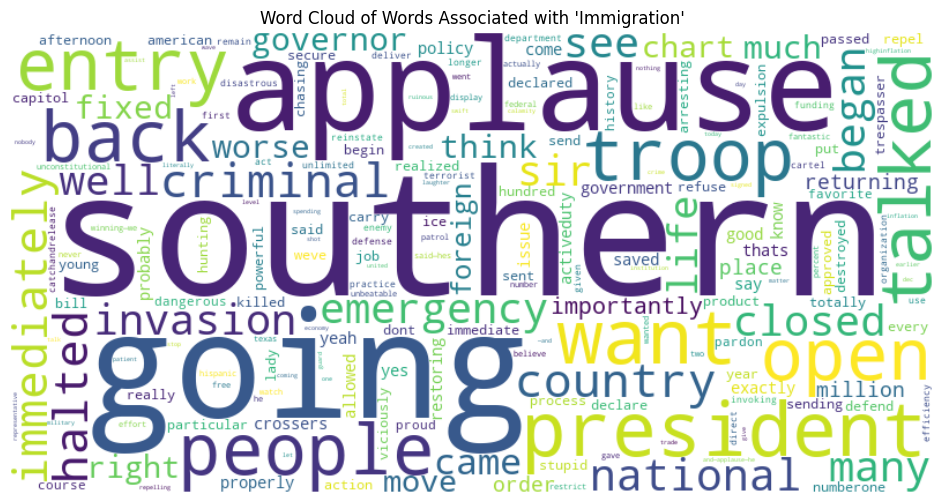

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a Word Cloud from associated words
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Words Associated with 'Immigration'")
plt.show()


## Refinement of the word cloud:

I removed the terms 'President' , 'applause' and 'talked' as stop-words in this context and retained the others in the word cloud. 

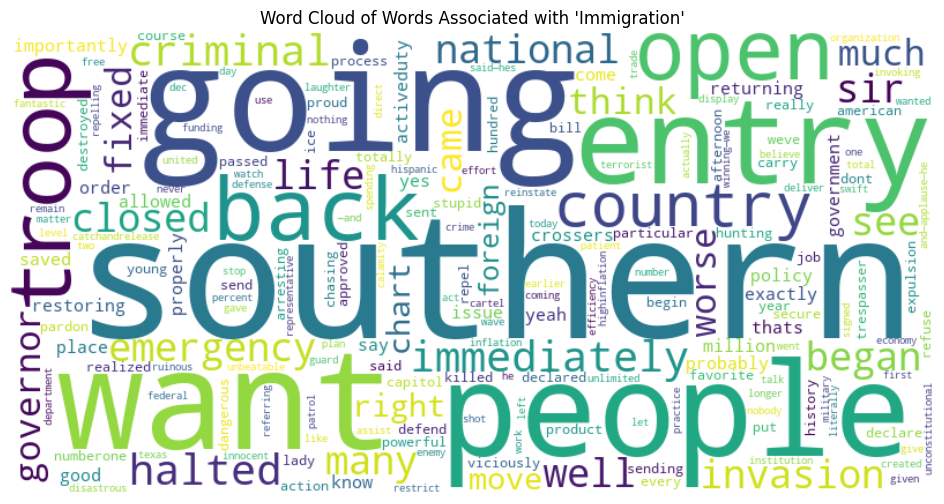

In [61]:
# word cloud after removing  'president' , 'applause' , 'talked'
# 
remove_words = ["president", "applause", "talked"]

# Remove unwanted words from word frequency dictionary
for word in remove_words:
    word_freq.pop(word, None)  # Safely remove without errors

# Generate a new Word Cloud without the unwanted words
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

# Display the updated Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Words Associated with 'Immigration'")
plt.show()


## Who were the cabinet members associates Trump mentioned the most?

C:\Users\sfaiz\AppData\Local\Temp\ipykernel_71012\2216504857.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(cabinet_names)).colors


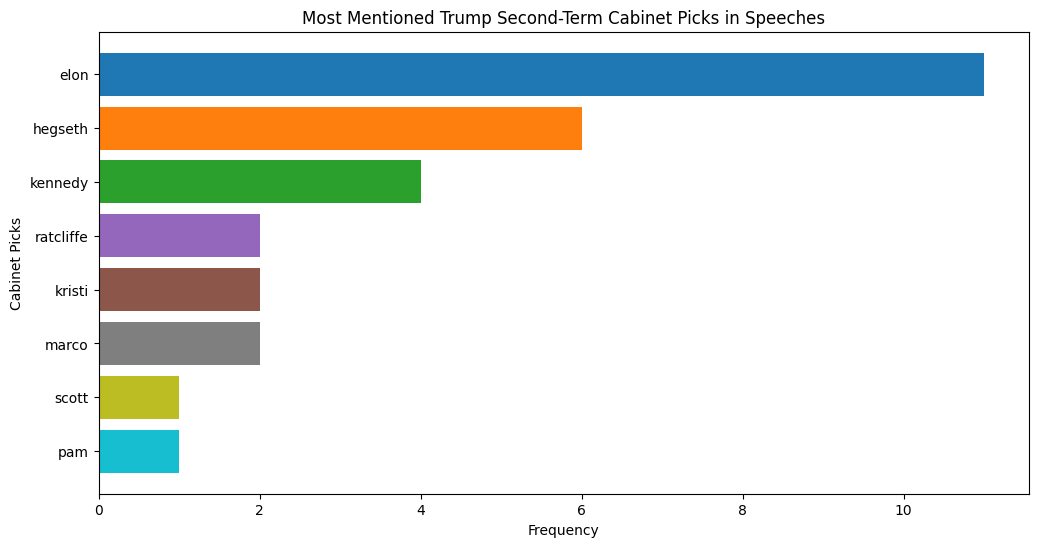

In [74]:

    # Define the list of Trump’s second-term cabinet picks, including Elon Musk
cabinet_picks = [
        "marco", "scott", "hegseth", "pam", "burgum",
        "brooke", "kennedy", "scott", "sean",
        "chris", "doug", "kristi", "tulsi", "vought",
        "ratcliffe", "zeldin", "elon", 
    ]

   

    # Count mentions of each cabinet pick
cabinet_freq = Counter(word for word in all_words_lower if word in cabinet_picks)

   

# Extract names and counts
cabinet_names, counts = zip(*cabinet_freq.most_common(len(cabinet_picks)))

# Generate unique colors for each name using a colormap
colors = plt.cm.get_cmap("tab10", len(cabinet_names)).colors

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.barh(cabinet_names, counts, color=colors)
plt.xlabel("Frequency")
plt.ylabel("Cabinet Picks")
plt.title("Most Mentioned Trump Second-Term Cabinet Picks in Speeches")
plt.gca().invert_yaxis()  # Reverse order for readability

# Show the plot
plt.show()

**Elon Musk** is mentioned more often than any cabinet member. This is an interesting fact.

In [69]:
len(all_words_lower)



23981

# Parts of Speech Analysis

I analyzed Trumps speeches using the Parts of Speech analysis to bring forth the hidden patterns in his syntax usage.

## Noun Analysis

We include Common and Proper nouns in both the singular and the plural form in the analysis. 

In [ ]:
# Nouns 


# Perform POS tagging
pos_tags = nltk.pos_tag(all_words_lower)

# Extract nouns using the correct condition
nouns = [word for word, tag in pos_tags if tag in { "NN", "NNS", "NNP", "NNPS"}]

nouns_freq = Counter(nouns)




In [87]:
print(nouns_freq)


Counter({'president': 514, 'people': 311, 'thats': 140, 'country': 140, 'year': 137, 'thing': 123, 'state': 117, 'thank': 115, 'lot': 114, 'dont': 98, 'time': 94, 'laughter': 87, 'applause': 85, 'job': 82, 'youre': 79, 'world': 71, 'day': 68, 'way': 67, 'something': 64, 'theyre': 62, 'nation': 51, 'everybody': 50, 'didnt': 50, 'place': 49, 'america': 48, 'today': 48, 'number': 47, 'money': 47, 'life': 47, 'think': 47, 'tax': 46, 'week': 46, 'war': 45, 'governor': 45, 'order': 43, 'deal': 43, 'problem': 42, 'work': 39, 'nobody': 37, 'sir': 37, 'border': 37, 'government': 36, 'peace': 34, 'vote': 34, 'get': 34, 'guy': 33, 'talk': 33, 'everything': 32, 'administration': 31, 'history': 31, 'price': 31, 'water': 30, 'see': 29, 'carolina': 28, 'tariff': 28, 'question': 28, 'know': 27, 'trump': 27, 'yeah': 27, 'month': 26, 'reason': 26, 'oil': 26, 'election': 25, 'speech': 25, 'group': 25, 'mean': 25, 'leader': 25, 'minister': 25, 'cant': 24, 'anything': 24, 'percent': 24, 'hell': 23, 'system

A word cloud was generated to visualize the nouns.

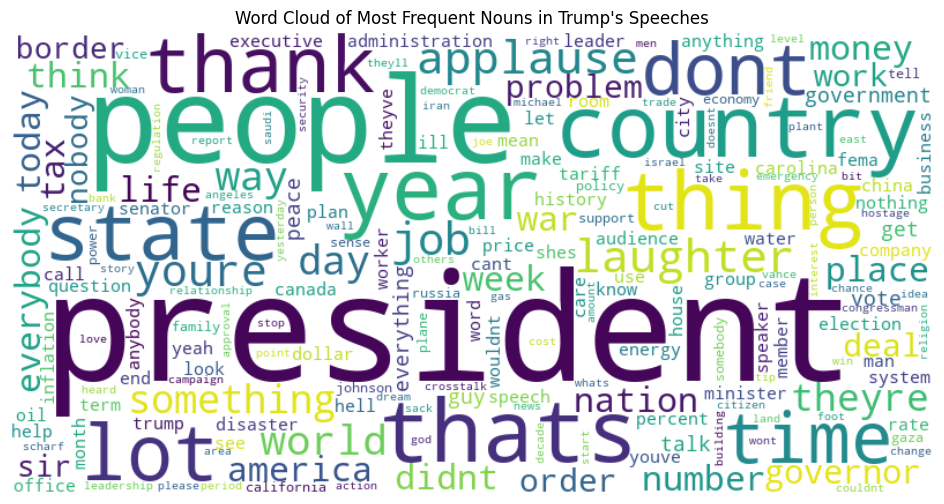

In [90]:
# Generate the Word Cloud
wordcloud_noun = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(nouns_freq)

# Display the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_noun, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Nouns in Trump's Speeches")
plt.show()

## Which were the verbs used most often by Donald Trump?

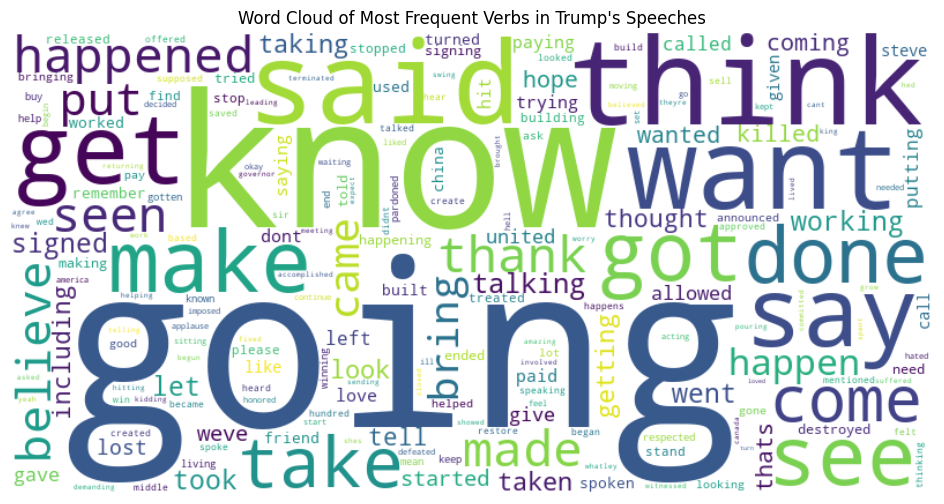

In [91]:
# Verbs

# Extract verbs using the correct condition
verbs = [word for word, tag in pos_tags if tag in {"VB", "VBD", "VBG", "VBN", "VBP", "VBZ"}]

# Count frequency of verbs
verbs_freq = Counter(verbs)

# Generate the Word Cloud for verbs
wordcloud_verbs = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(verbs_freq)

# Display the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_verbs, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Verbs in Trump's Speeches")
plt.show()


## The adjectives used most often by Donald Trump:

Trumps idiosyncratic style of political rhetoric is marked by a uniquely exuberant use of superlatives and comparison. Words like 'great' , 'greatest' , 'best' are used liberally throughout, often emphasized for added effect.

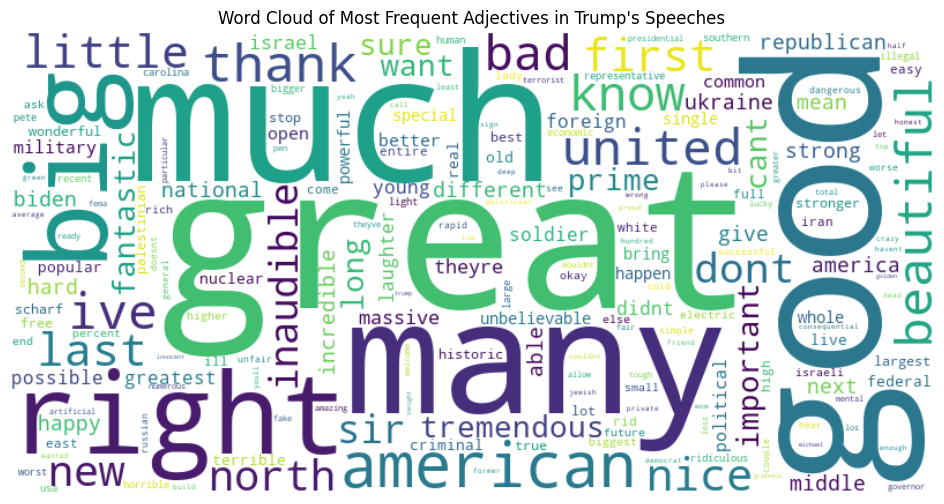

In [92]:
# Adjectives
# Extract adjectives
adjectives = [word for word, tag in pos_tags if tag in {"JJ", "JJR", "JJS"}]

# Count frequency of adjectives
adjectives_freq = Counter(adjectives)

# Generate the Word Cloud for adjectives
wordcloud_adj = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(adjectives_freq)

# Display the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_adj, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Adjectives in Trump's Speeches")
plt.show()

It is not surprising that the word 'great' which forms part of Trumps election campaign motto 'Make America Great Again' dominates the adjective space in the vocabulary. 

## **Sentiment Analysis**
We'll use **Huggingface BERT based model distilbert-base-uncased-finetuned-sst-2-english ** to analyze Trump's speeches for **positive, negative, and neutral sentiment**.

## PLEASE NOTE
**Since the Sentiment analysis using BERT required a GPU to process the more than 23,000 words of the Trump speeches, the code, as a google colab notebook, has been provided in another notebook, as google colab A100 GPU was deployed for the analysis.** 


## We used n-grams to analyze Trumps phraseology:

In [138]:
from nltk.util import ngrams
from collections import Counter



def get_ngrams(words_list, n=2):
    return list(ngrams(words_list, n))

    # Extract bigrams from all_words_lower
bigrams = get_ngrams(all_words_lower, n=2)

    # Count the most common bigrams
bigram_freq = Counter(bigrams).most_common(20)

    # Convert to DataFrame for better readability
df_bigrams = pd.DataFrame(bigram_freq, columns=["Bigram", "Frequency"])

    # Display the DataFrame
print("Top 20 Bigrams:")
print(df_bigrams)




Top 20 Bigrams:
                Bigram  Frequency
0        (thank, much)         78
1      (united, state)         56
2    (president, well)         46
3         (dont, know)         45
4    (north, carolina)         37
5       (youre, going)         34
6         (four, year)         31
7     (sir, president)         28
8       (middle, east)         28
9      (theyre, going)         28
10      (thank, thank)         27
11       (want, thank)         25
12        (dont, want)         25
13   (prime, minister)         25
14       (lot, people)         24
15   (president, yeah)         24
16      (thats, going)         23
17  (thank, president)         21
18        (going, get)         21
19  (executive, order)         20


## Visualizing the Bigrams

C:\Users\sfaiz\AppData\Local\Temp\ipykernel_71012\2687179294.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(df_bigrams)).colors


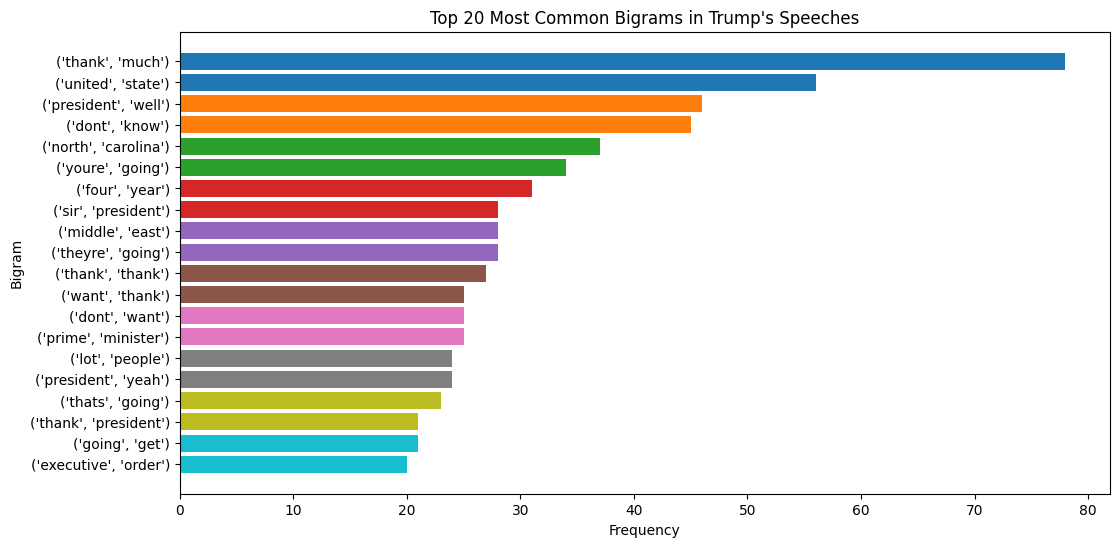

In [139]:
# Generate unique colors for each name using a colormap
colors = plt.cm.get_cmap("tab10", len(df_bigrams)).colors


    # Plot bar graph of most mentioned bigrams
plt.figure(figsize=(12, 6))
plt.barh(df_bigrams["Bigram"].astype(str), df_bigrams["Frequency"], color=colors)
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.title("Top 20 Most Common Bigrams in Trump's Speeches")
plt.gca().invert_yaxis()  # Reverse order for readability
plt.show()    


## Using n-grams to check the most prominent four word phrases:

In [140]:
from nltk.util import ngrams
from collections import Counter



def get_ngrams(words_list, n=4):
    return list(ngrams(words_list, n))

    # Extract bigrams from all_words_lower
fourgrams = get_ngrams(all_words_lower, n=4)

    # Count the most common bigrams
fourgram_freq = Counter(fourgrams).most_common(20)

    # Convert to DataFrame for better readability
df_fourgrams = pd.DataFrame(fourgram_freq, columns=["Fourgram", "Frequency"])

    # Display the DataFrame
print("Top 20 Fourgrams:")
print(df_fourgrams)

Top 20 Fourgrams:
                                Fourgram  Frequency
0       (make, america, great, applause)          5
1         (president, well, thank, much)          5
2           (good, thing, going, happen)          5
3    (prime, minister, netanyahu, think)          5
4             (thank, much, thank, much)          4
5          (youve, done, fantastic, job)          4
6   (president, united, state, applause)          3
7        (applause, thank, thank, thank)          3
8            (thank, thank, thank, much)          3
9            (level, nobody, ever, seen)          3
10           (largest, amount, oil, gas)          3
11           (amount, oil, gas, country)          3
12            (oil, gas, country, earth)          3
13     (official, policy, united, state)          3
14           (two, gender, male, female)          3
15    (nation, suffered, greatly, going)          3
16           (thank, thank, much, thank)          3
17         (going, make, america, great)      

C:\Users\sfaiz\AppData\Local\Temp\ipykernel_71012\3532624085.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(df_fourgrams)).colors


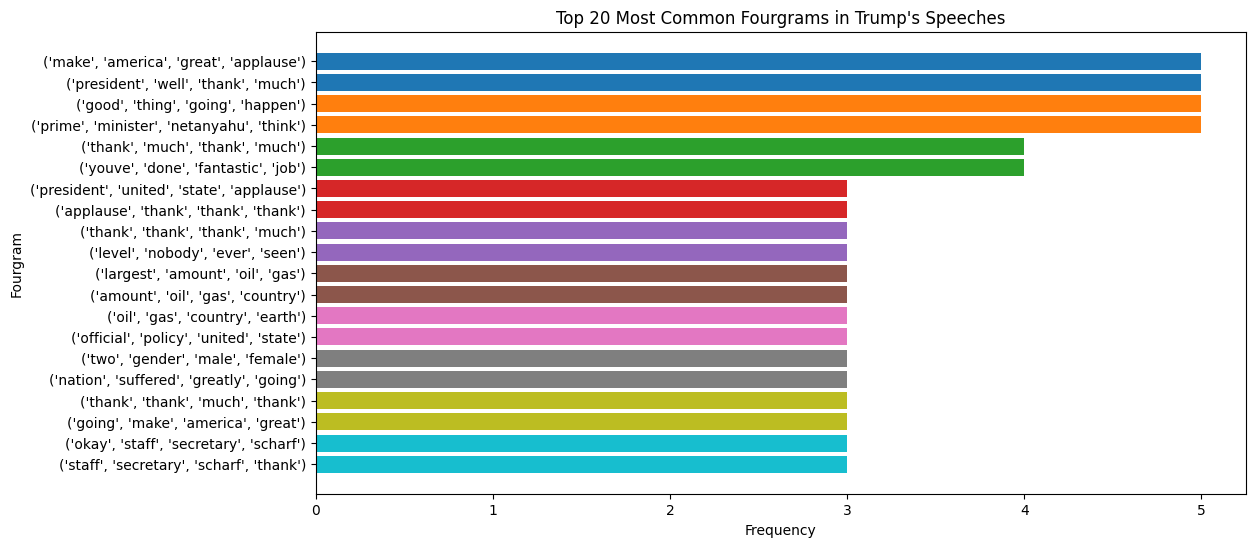

In [143]:
# Generate unique colors for each name using a colormap
colors = plt.cm.get_cmap("tab10", len(df_fourgrams)).colors


    # Plot bar graph of most mentioned bigrams
plt.figure(figsize=(12, 6))
plt.barh(df_fourgrams["Fourgram"].astype(str), df_fourgrams["Frequency"], color=colors)
plt.xlabel("Frequency")
plt.ylabel("Fourgram")
plt.title("Top 20 Most Common Fourgrams in Trump's Speeches")
plt.gca().invert_yaxis()  # Reverse order for readability
plt.show()    

Once again unsurprisingly 'Make America Great' which is part of Trumps motto followed by applause are the most common words to appear in a phrase. 

## NMF (Non-Negative Matrix Factorization)

**I used NMF (Non-Negative Matrix Factorization) to find the topic clusters and words that constitute those clusters in the corpus of Trumps speeches.**

In [150]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# Load the dataset
try:
    df = pd.read_csv("Trump_addresses.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset not found. Please ensure 'Trump_addresses.csv' is available.")
    df = None

# Proceed only if dataset is loaded
if df is not None:
    # Extract cleaned text
    speeches = df["Text"].dropna().astype(str).tolist()

    # Convert text data into a TF-IDF matrix
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english", max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(speeches)

    # Apply NMF for topic modeling
    num_topics = 5  # Define number of topics
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_topics = nmf_model.fit_transform(tfidf_matrix)

    # Get feature names (words)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Display top words for each topic
    num_top_words = 10
    topics_dict = {}

    for topic_idx, topic in enumerate(nmf_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics_dict[f"Topic {topic_idx+1}"] = top_words

    # Convert to DataFrame for display
    df_topics = pd.DataFrame(topics_dict)

    


Dataset loaded successfully.


The topics and possible elaboration of the topic semantic content is represented below

In [152]:
import seaborn as sns
# Display the topics DataFrame as a table
print("Top Words for Each Topic:")
print(df_topics.to_string(index=False))  # Print without row index




Top Words for Each Topic:
   Topic 1  Topic 2 Topic 3 Topic 4      Topic 5
      fema applause    pete  people       scharf
    people     want   march      mr        staff
  governor laughter    life      ll      cabinet
      want    great      mr      ve     chairman
california   people   cross   world appointments
     water  country   mitch    like      speaker
      like     said   plane  israel    secretary
        ve      big    talk   years       acting
        ll      did     did   peace      johnson
       lot    right hegseth     lot         okay


### **Interpretation of the above Topic word clusters**

| **Topic #** | **Top Words** | **Interpretation** |
|------------|-------------|---------------------------|
| **Topic 1** | *fema, governor, california, water* | **Emergency Response to the California Fires/ Natural Disasters** (FEMA is the Federal Emergency Management Agency, linked to disasters) |
| **Topic 2** | *applause, want, laughter, great* | **Public Speech / Crowd Reactions to the phrase MAGA (Make America Great Again)** (Includes applause, laughter, audience engagement) |
| **Topic 3** | *pete, march, life, cross* | **Names and Events** (Possibly mentioning Pete Buttigieg, political marches) |
| **Topic 4** | *people, mr, ll, world, peace* | **General Political Speech** (Mentions of global affairs, people, peace) |
| **Topic 5** | *scharf, staff, cabinet, chairman, appointments* | **Government Positions / Administration** (Mentions William Owen Scharf who serves as the White House staff secretary in the second Donald Trump administration. ) |


## Please Note##: 

**The BERT based Sentiment Analysis is in another Notebook , which has also been submitted in the assignment. The separate notebook was necessitated by the fact that the BERT based Transformer required a GPU for optimal performance. Therefore, a A100 GPU, requisitioned from Google Colab was deployed for the Analysis.**